In [1]:
import time
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import combinations
from functools import partial
from multiprocessing import Pool
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.model_selection import RepeatedKFold
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split

## Personal Modules
import ReadStandardTimeFill as RSTF
import LSTM_Train as LSTM

%matplotlib inline
%config IPCompleter.greedy=True
plt.rcParams["figure.figsize"] = (14, 8)

    N  T  MSE  STD
0  63  5  0.0  0.0
1  98  3  0.0  0.0
2  90  9  0.0  0.0
3  32  9  0.0  0.0
4  70  6  0.0  0.0
5  87  8  0.0  0.0
{'T_Max': 10, 'proc': 3, 'N_Max': 100, 'epochs': 1000, 'Searches': 2, 'Y': 'fch4', 'reps': 5}


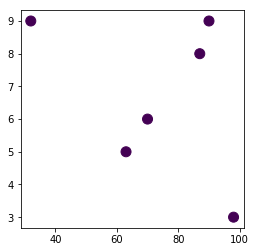

In [2]:
class Params:
    def __init__(self,Func,Y):
        if Func == 'Full':
            epochs = 1000
            reps = 50
            N_Max = 200
            T_Max = 48
            samp_size = 20
            Searches = 10
        else:
            epochs = 1000
            reps = 5
            N_Max = 100
            N_min = 2
            T_Max = 10
            samp_size = 6
            Searches = 2
        N = np.array(np.random.rand(samp_size)*N_Max+N_min,dtype='int32')
        T = np.array(np.random.rand(samp_size)*T_Max,dtype='int32')
        d = {'N':N,'T':T}
        self.Runs = pd.DataFrame(data=d)
        self.params = {}
        self.params['T_Max'] = T_Max
        self.params['N_Max'] = N_Max
        self.params['reps'] = reps
        self.params['epochs'] = epochs
        self.params['Y'] = Y
        self.params['proc']=3
        self.params['Searches']=Searches

rpms = Params('Test','fch4')
# rpms = Params('Test',5,'ch4_flux')
Runs,params = rpms.Runs,rpms.params
Runs['MSE'] = 0.0
Runs['STD'] = 0.0
print(Runs)
print(params)
plt.figure(figsize = (4,4))
plt.scatter(Runs["N"],Runs['T'],s=100,c=Runs['MSE'])

Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.


(1737, 1)
0.451973744141
Finisehd Run  0
 Stats: 
N      63.000000
T       5.000000
MSE     0.584069
STD     0.125325
Name: 0, dtype: float64
(1739, 1)
0.259277775002
Finisehd Run  1
 Stats: 
N      98.000000
T       3.000000
MSE     0.532158
STD     0.132333
Name: 1, dtype: float64
(1733, 1)
0.150929216913
Finisehd Run  2
 Stats: 
N      90.000000
T       9.000000
MSE     0.634825
STD     0.042940
Name: 2, dtype: float64
(1733, 1)
0.303219422291
Finisehd Run  3
 Stats: 
N      32.000000
T       9.000000
MSE     0.625349
STD     0.022423
Name: 3, dtype: float64
(1736, 1)
0.253839767003
Finisehd Run  4
 Stats: 
N      70.000000
T       6.000000
MSE     0.570864
STD     0.084591
Name: 4, dtype: float64
(1734, 1)
-0.117185183468
Finisehd Run  5
 Stats: 
N      87.000000
T       8.000000
MSE     0.592393
STD     0.062573
Name: 5, dtype: float64
    N  T       MSE       STD
0  63  5  0.584069  0.125325
1  98  3  0.532158  0.132333
2  90  9  0.634825  0.042940
3  32  9  0.625349  0.022423
4 

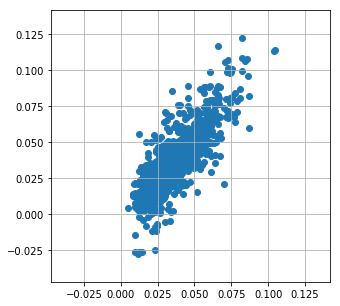

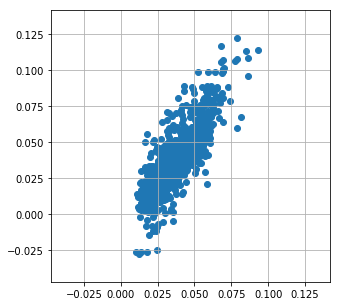

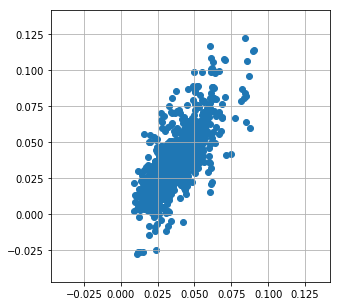

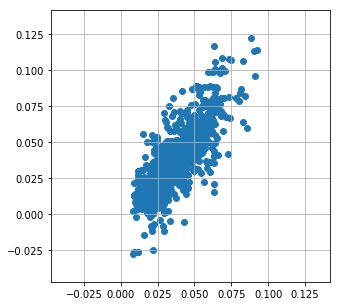

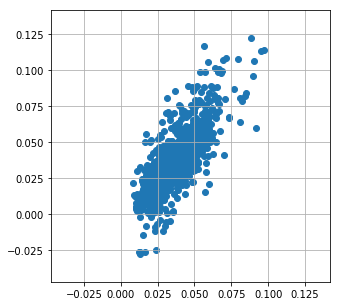

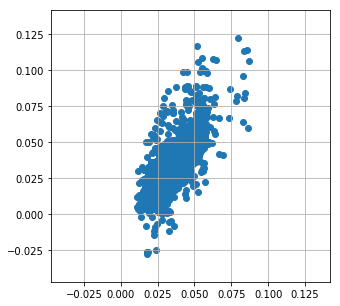

In [3]:
def TTV_Split(i,Memory,X,y,params):
    X_train,X_test,y_train,y_test=train_test_split(X,y, test_size=0.1, random_state=i)
    X_train,X_val,y_train,y_val=train_test_split(X_train,y_train, test_size=0.11, random_state=i)
    return(LSTM.Train_Steps(params['epochs'],params['N'],X_train,X_test,X_val,y_train,y_test,y_val,i,X_fill = X,Memory=Memory))


Full = ['H','LE','Fco2','fco2','fch4','Wind Spd','air pressure','Ta','Rn','PPFD','Rain','Water Table','Ts 2.5 cm',
         'Ts 15 cm','VWC','Active Layer','24H Rain','Wtr Tbl Trnd','ET']

Model = ['H','Wind Spd','air pressure','Ta','Rn','PPFD','Ts 2.5 cm','Ts 15 cm',
         'VWC','Active Layer','24H Rain','Wtr Tbl Trnd','ET']


# Model = ['Water Table']

# Model = [' Active Layer','H']

Time = time.time()

Path = 'FilteredData2018-04-04.csv'


def RunReps(Model,Runs,params,pool = None):
    RST = RSTF.ReadStandardTimeFill(Path)#ReadStandardTime(Path)
    offset = 5/params['proc']
    Memory = (math.floor(100/params['proc'])- offset) * .01
    MSE = []
    RST.Scale(params['Y'],Model)
    RST.TimeShape(params['T'])
    y = RST.y_time*1.0
    X = RST.X_time*1.0
    MSE = []
    Y_fill = []
    if __name__=='__main__'and params['proc'] != 1:
        for i,results in enumerate(pool.imap(partial(TTV_Split,Memory=Memory,X=X,y=y,params=params),range(params['reps']))):
            mse = results[0]
            y_fill = results[1]
            Y_fill.append(y_fill)
            MSE.append(mse)
    else:
        for i in range(params['reps']):
            results = TTV_Split(i,Memory,X,y,params)
            mse = results[0]
            MSE.append(mse)
            y_fill = results[1]
            Y_fill.append(y_fill)
    MSE = np.asanyarray(MSE)
    Y_fill = np.asanyarray(Y_fill).mean(axis=0)#.mean(axis=0)
    print(Y_fill.shape)
#     RST.Fill(Y_fill,'Fch4')
    y = RST.YScaled.inverse_transform(y)
    Y_fill = RST.YScaled.inverse_transform(Y_fill)
    
    plt.figure(figsize=(5,5))
    plt.scatter(Y_fill,y)
    yl = plt.ylim()
    plt.xlim(yl[0],yl[1])
    plt.grid()
    print(metrics.r2_score(Y_fill,y))
    return(MSE)
    

if __name__=='__main__'and params['proc'] != 1:
    pool = Pool(processes=params['proc'],maxtasksperchild=75)
else:pool=None
    

for i in Runs.index:
    params['T']=Runs['T'].iloc[i]
    params['N']=Runs['N'].iloc[i]
    MSE = RunReps(Model,Runs,params,pool)#RunFunc(i,processes=processes,Modz=Model,reps=reps,epochs=epochs,params=Runs)
    Runs['MSE'][i]=MSE.mean()
    Runs['STD'][i]=MSE.std()
    print('Finisehd Run ',str(i))
    print(' Stats: ')
    print(Runs.iloc[i])

print(Runs)
  
print(time.time()-Time)
        

(100, 10) (100, 10)
[[  0.   0.]
 [  1.   1.]
 [  2.   2.]
 ..., 
 [ 97.   7.]
 [ 98.   8.]
 [ 99.   9.]]
(100, 10)


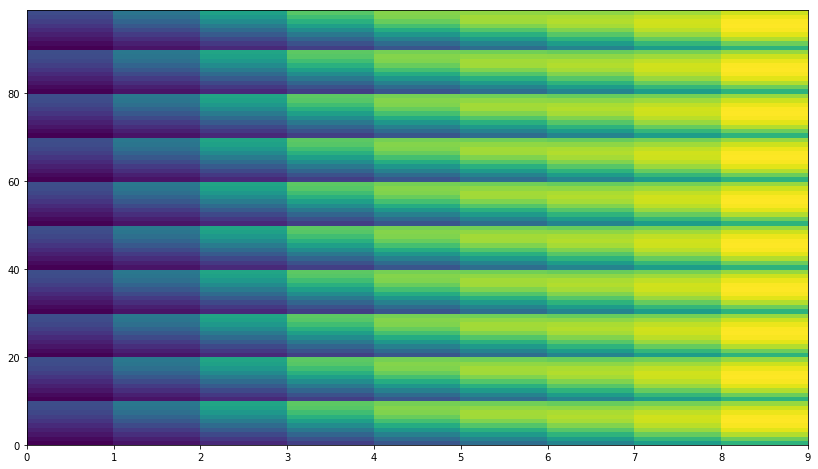

In [4]:
from scipy.stats import norm

plt.rcParams["figure.figsize"] = (14, 8)
def probability_of_improvement(mu_x, sigma_x, opt_value, kappa=0.5):
    gamma_x = (mu_x - opt_value - kappa) / sigma_x
    return norm.cdf(gamma_x)


def expected_improvement(mu_x, sigma_x, opt_value, kappa=0.5):
    gamma_x = (mu_x - opt_value - kappa) / sigma_x
    return sigma_x * (gamma_x * norm.cdf(gamma_x) + norm.pdf(gamma_x))


def upper_confidence_bound(mu_x, sigma_x, opt_value, kappa=-1.0):
    return mu_x + kappa * sigma_x

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, WhiteKernel

kernel = Matern(length_scale = [50,3],length_scale_bounds="fixed")
gp = GaussianProcessRegressor(kernel=kernel, alpha=Runs['STD'].values, random_state=0,normalize_y=False)
gp.fit(Runs[['N','T']].values, Runs['MSE'].values)


N = [n for n in range(params['N_Max'])]
T = [t for t in range(params['T_Max'])]
A = [T[i] for j in range(len(N))for i in range(len(T))]
B = [N[i] for j in range(len(T))for i in range(len(N))]
T = np.asanyarray(A)
N = np.asanyarray(B)


X = np.zeros(shape=(T.shape[0],2))
X[:,0] = N
X[:,1] = T

Xi = np.arange(N.min(),N.max()+.1,1)
Yi = np.arange(T.min(),T.max()+.1,1)
xi,yi = np.meshgrid(Yi,Xi)

print(xi.shape,yi.shape)

print(X)

y_pred,sigma = gp.predict(X,return_std=True)
y_predi = y_pred.reshape(Xi.shape[0],Yi.shape[0])

print(y_predi.shape)

plt.figure()
plt.pcolor(xi,yi,y_predi)
# plt.scatter(X[:,0],X[:,1],c=y_pred)#[:,0],X[:,1],y_pred)
plt.legend()
Runs2 = Runs.copy()

[ 99.9081789    1.17788343]
100 1
(1734, 1)
-0.109133627754
[ 0.64918263  0.57866196  0.62209167  0.63426679  0.48666913]
[ 96.77056982   5.32488451]
97 5
(1734, 1)
-0.116659026676
[ 0.6491754   0.57933679  0.62233481  0.63446273  0.48144108]
        MSE    N       STD  T
0  0.625349   32  0.022423  9
1  0.584069   63  0.125325  5
2  0.570864   70  0.084591  6
3  0.592393   87  0.062573  8
4  0.634825   90  0.042940  9
5  0.593350   97  0.060608  5
6  0.532158   98  0.132333  3
7  0.594174  100  0.058670  1


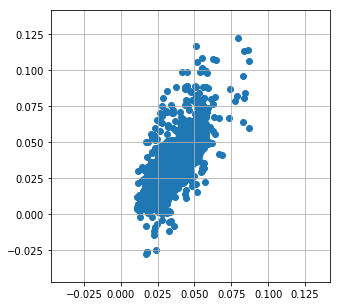

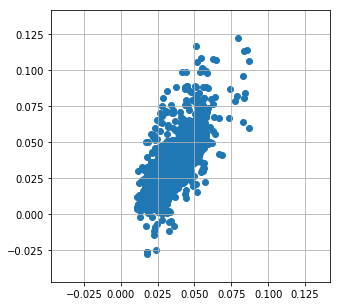

In [5]:
from scipy.optimize import minimize
acq = upper_confidence_bound
def query(xi, yi, gp):
    best_value = np.inf

    for N in np.linspace(1,params['N_Max']):
        for T in np.linspace(0,params['T_Max']):
            def obj(x):
                x=x.reshape(1,-1)
                mu_x, sigma_x = gp.predict(x, return_std=True)
#                 print(np.min(yi),np.max(yi))
                return acq(mu_x, sigma_x, np.min(yi))
            x0 = np.asanyarray([N,T]).reshape(1,2)
            res = minimize(obj, x0, bounds=((1, params['N_Max']),(0,params['T_Max'])))

            if res.fun < best_value:
                best_value = res.fun
                query_point = res.x
    query_point = query_point
    return query_point

for i in range(params['Searches']):
    kernel = Matern(length_scale_bounds="fixed") 
    gp = GaussianProcessRegressor(kernel=kernel, alpha=Runs['STD'].values, random_state=1,normalize_y=True)
    gp.fit(Runs[['N','T']].values, Runs['MSE'].values)
    
    next_x = query(Runs[['N','T']].values, Runs['MSE'].values, gp)
    print(next_x)
    N = int(np.round(next_x[0],0))
    T = int(np.round(next_x[1],0))
    o = 0
    while len(Runs.loc[(Runs['N']==N) & (Runs['T']==T)].index) != 0:
        print('Adjust!')
        o +=1
        N += int(o*np.cos(o*np.pi))
    print(N,T)
    d = {'N':N,'T':T,'MSE':0,'STD':0}
    idx = Runs.index[-1] + 1
    D2 = pd.DataFrame(data=d,index=[idx])
    Runs = Runs.append(D2)
    
    MSE = RunReps(Model,Runs,params,pool)#RunFunc(i,processes=processes,Modz=Model,reps=reps,epochs=epochs,params=Runs)
    print(MSE)
    Runs['MSE'][idx]=MSE.mean()
    Runs['STD'][idx]=MSE.std()
    
    Runs = Runs.sort_values(by = ['N','T']).reset_index(drop=True)
    
print(Runs)

if __name__=='__main__'and params['proc'] != 1:
    pool.close()

        MSE   N       STD  T
6  0.532158  98  0.132333  3


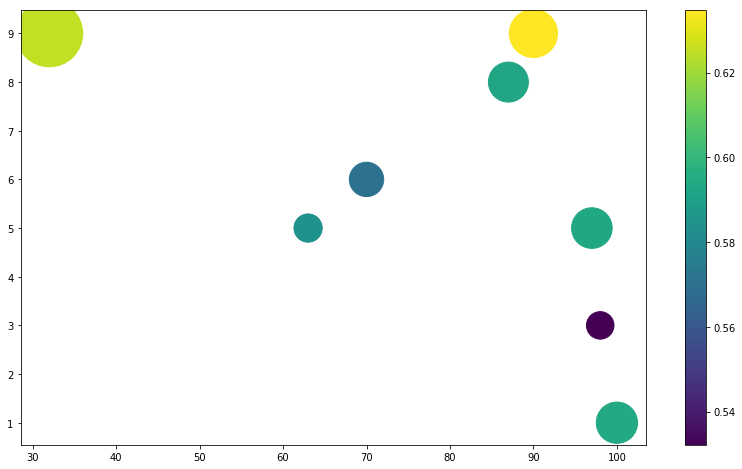

In [6]:
print(Runs[Runs['MSE'] == Runs['MSE'].min()])
plt.figure()
plt.scatter(Runs["N"],Runs['T'],s=1/Runs['STD']*100,c=Runs['MSE'])
plt.colorbar()
# plt.legend()

CH4 Results: 
    
      MSE     N     STD     T
12  0.233444  23  0.031446  0

CH4 Results:

         MSE   N      STD  T
10  0.061422  82  0.01039  2